Part A asks to create an artificial 3D vector field with 2D horizontal vectors.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

Part B asks to create an artificial vector field. This will be a 3 dimensional field with 2d horizontal vecotors. The artificial vector field will be composed by creating a column vector that is copied to the other places. There will be two profiles selected, the log law and power law profiles. An Ekman spiral will also be added to the vector. Variation will be added with up to a random 10% "kick".

In [2]:
''' A 1 km square with a height of 300 meters is going to be used with a 1000 vertical point resolution.
The column vector will be a 1000 by 2 matrix. This is 1000 rows with 2 columns. Each row will the vector at a discrete height. The two columns will correspond to a u and v component of the vector.'''
height = 300 # number of meters in height
number_of_vertical_points = 1000 # resolution in meters
ColumnVecSize = (number_of_vertical_points,2) # size of column vector using the height and resolution
# Allocation of memory for column vector
ColumnVector_loglaw = np.zeros(ColumnVecSize, dtype=float) # float data type designation
z_location = np.linspace(0,height, number_of_vertical_points,dtype=float)


roughness_parameter = 0.01 # Common roughness parameter for crop/flat land region
Karman_const = 0.41 # Karman constant for log law
u_friction_velocity = 1.2 * Karman_const # number is picked to have Uinf close to 12 m/s
U_z = u_friction_velocity/Karman_const * np.log(z_location/roughness_parameter) # log law
U_z[0] = 0 # sets NaN part due to ln(0) to 0 at boundary

ColumnVector_loglaw[:,0] = U_z # assign U to the column vector U position

C:\Users\trevo\AppData\Local\Temp\ipykernel_11572\862430883.py:14: RuntimeWarning: divide by zero encountered in log
  U_z = u_friction_velocity/Karman_const * np.log(z_location/roughness_parameter) # log law


In [3]:
from EkmanSpiral import Ekman_Spiral
ColumnVector_loglaw_spiral = Ekman_Spiral(ColumnVector_loglaw,z_location) # add spiral component to field

In [4]:
import Create3DSpace
x, y, space = Create3DSpace.Space_Field(ColumnVector_loglaw_spiral, 300, 100)  # space is a 4d matrix defined as follows [x, y, z, vector selection (u=1 v=2)]. The last two dimensions are the original 

space_kicked = Create3DSpace.kick(space,0.05)# 5% random kick to each individual value

In [5]:
from Matlab_Import import LidarData, matlabimport
lidar_data = matlabimport()  # get matlab data
""" runs matlab import code. List is of object class lidarData which has a date, and 4 matrices named aximuth, elevation, rad_vector, and range. To access each set of lidar data use lidar_data.'name of variable matrix'
"""


" runs matlab import code. List is of object class lidarData which has a date, and 4 matrices named aximuth, elevation, rad_vector, and range. To access each set of lidar data use lidar_data.'name of variable matrix'\n"

In [6]:
import Slicing_and_Interp as SandI

elevation = np.array([75])  # set elevation of scan
number_of_scans = 80  # number of scans per range ring
azimuthals = np.reshape(np.linspace(0, 360, number_of_scans), (-1, 1))  # evenly spaced angles for azimuth rotation
lidar_location = np.array([x[50], y[50], 0])  # define lidar location
# create space for iterating variables
u_interp_val = np.zeros((len(z_location)-1, number_of_scans))  
v_interp_val = np.zeros((len(z_location)-1, number_of_scans))
x_lidar = np.zeros((len(z_location)-1, number_of_scans))
y_lidar = np.zeros((len(z_location)-1, number_of_scans))
z_lidar = np.zeros((len(z_location)-1, number_of_scans))

# loop for each horizontal plane, exclude 0 plane
for i in np.arange(1, len(z_location)):
    u_interp_val[i-1, :], v_interp_val[i-1, :], x_lidar[i-1, :], y_lidar[i-1, :], z_lidar[i-1, :] = SandI.slice_points(space_kicked, x, y, z_location, azimuthals, elevation, z_location[i], lidar_loc=lidar_location)

# space for projection iterables
laser_vect = np.zeros((np.size(x_lidar, axis=0), np.size(x_lidar, axis=1), 3)) 
laser_speed = np.zeros_like(x_lidar)

# loop to get speeds and laser vectors
for i in np.arange(np.size(laser_speed, axis=0)):
    measlocation = np.hstack((x_lidar[i, :].reshape((-1,1)), y_lidar[i, :].reshape((-1,1)), z_lidar[i, :].reshape((-1,1))))
    laser_vect[i, :, :], laser_speed[i, :] = SandI.vectorProjection(u_interp_val[i, :].T, v_interp_val[i, :].T, measlocation, lidar_location)
    
    

In [15]:
import VAD_Alg as VAD

lidar_VAD_loglaw = []
for i in range(np.size(laser_vect, axis=0)):
    VAD_output = VAD.vad_extraction(laser_vect[i, :, :], laser_speed[i, :].reshape(-1, 1))
    VAD_output_vect = VAD_output[0]
    lidar_VAD_loglaw.append(VAD_output_vect)
    
    

C:\Users\trevo\PycharmProjects\MAE579\Wind Energy Project\VAD_Alg.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  Xhat = np.linalg.lstsq(normed_rad_vect, radial_velocity)


In [19]:
u_actual_velocities_plot = space_kicked[50, 50, :, 0]
v_actual_velocities_plot = space_kicked[50, 50, :, 1]
z_actual_plot = z_location
z_measure_plot = z_location[1:]
lidar_VAD_loglaw_array = np.stack(lidar_VAD_loglaw, axis=0)
u_meas_plot = lidar_VAD_loglaw_array[:, 0]
v_meas_plot = lidar_VAD_loglaw_array[:, 1]

dir_actual = np.rad2deg(np.arctan(v_actual_velocities_plot/u_actual_velocities_plot))
dir_meas = np.rad2deg(np.arctan(v_meas_plot/u_meas_plot))


C:\Users\trevo\AppData\Local\Temp\ipykernel_11572\2432530481.py:9: RuntimeWarning: invalid value encountered in divide
  dir_actual = np.rad2deg(np.arctan(v_actual_velocities_plot/u_actual_velocities_plot))


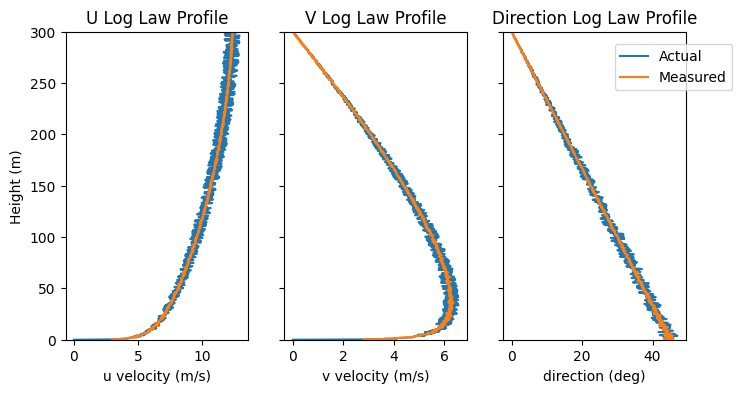

In [36]:
fig_1, ax_1 = plt.subplots(figsize=(8, 4), nrows=1, ncols=3)
# plt.tight_layout()
ax_1[0].set_title('U Log Law Profile')
ax_1[1].set_title('V Log Law Profile')
ax_1[2].set_title('Direction Log Law Profile')
ax_1[0].set_ylabel('Height (m)')
ax_1[0].set_xlabel('u velocity (m/s)')
ax_1[1].set_xlabel('v velocity (m/s)')
ax_1[2].set_xlabel('direction (deg)')
ax_1[0].set_ylim([0, 300])
ax_1[1].set_ylim([0, 300])
ax_1[2].set_ylim([0, 300])
ax_1[1].yaxis.set_tick_params(labelleft=False)
ax_1[2].yaxis.set_tick_params(labelleft=False)

ax_1[0].plot(u_actual_velocities_plot,z_actual_plot, label='Actual')
ax_1[0].plot(u_meas_plot,z_measure_plot, label='Measured')
ax_1[1].plot(v_actual_velocities_plot,z_actual_plot, label='Actual')
ax_1[1].plot(v_meas_plot,z_measure_plot, label='Measured')
ax_1[2].plot(dir_actual,z_actual_plot, label='Actual')
ax_1[2].plot(dir_meas,z_measure_plot, label='Measured')

handles, labels = ax_1[0].get_legend_handles_labels()
fig_1.legend(handles, labels, loc=(0.82, 0.77))
fig_1.savefig('Artificial Wind Profile.png')